In [22]:
%load_ext autoreload
%autoreload 2


import os
import sys

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC
from numpyro.infer.util import initialize_model
from numpyro import handlers

jax.config.update("jax_enable_x64", True)

sys.path.append('../')

from cofilin.forward_model.config import Constants, FMConfig
from cofilin.forward_model.fmodel import FModel
from cofilin.forward_model.fourier import my_ifft
from cofilin.forward_model.bias import manage_params
from cofilin.forward_model.plot_utils import plot_cubes, compare_pow_spec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
N, Z_I, Z_F = 64, 99, 0
R = 3.4*4
L = R*N

cte = Constants(N, L, Z_I, Z_F)

lpt_method = "1LPT"
MND = 1e-2
N_TR = L**3 * MND

det_bias_model = "PowerLaw"
stoch_bias_model = "Poisson"

fm_cfg = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    N_TR=N_TR,
    det_bias_model=det_bias_model,
    stoch_bias_model=stoch_bias_model,
)
fmodel = FModel(fm_cfg)

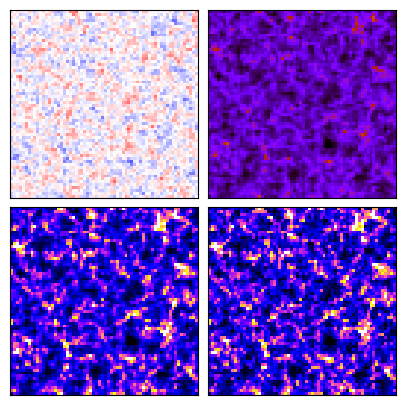

In [24]:
q_data = fmodel.input_arr(jax.random.PRNGKey(1))
delta_in_hat = fmodel.delta_in(q_data)
delta_in = my_ifft(delta_in_hat, cte.INV_L3)
delta_lpt = fmodel.delta_lpt(q_data)

get_n_tr_mean = fmodel.n_tr_mean()

params = {"alpha": 1.2}
params = manage_params(params)
n_tr_mean = get_n_tr_mean(delta_lpt, params)

key_sample = jax.random.PRNGKey(1)
n_tr_data = fmodel.sample_n_tr(n_tr_mean, key_sample)

lim_dev = 10 * jnp.std(delta_lpt)
vlim_dev = (-1, lim_dev)

lim_n_tr = jnp.mean(n_tr_data) + 3 * jnp.std(n_tr_data)
vlim_n_tr = (0, lim_n_tr)

fig, ax = plot_cubes(
    [delta_in, delta_lpt, n_tr_mean, n_tr_data],
    cmap=["seismic_r", "gnuplot"]+["gnuplot2"]*2,
    vlim=[0.1, vlim_dev]+[vlim_n_tr]*2,
    width=1, axis=2, idx=N//2
)

In [26]:
alpha_fixed = params["alpha"]

model = fmodel.build_model() 

conditioned_model = handlers.condition(
    model,  # the model that still has sample("alpha", …)
    data={"alpha": jnp.array(alpha_fixed)},
)

def tempered_conditioned_model(data, T=1):
    """Posterior ∝  [prior * likelihood]^(1/T)"""
    with handlers.scale(scale=1.0 / T):
        conditioned_model(data)

def tempered_model(data, T=1):
    """Posterior ∝  [prior * likelihood]^(1/T)"""
    with handlers.scale(scale=1.0 / T):
        model(data)

key_q_init = jax.random.PRNGKey(11) 
q_init = fmodel.input_arr(key_q_init) * 1
init_params = {"q": q_init} 

### HMC conditioned

In [ ]:
step_size = 1e-3  # choose by trial – no adaptation will adjust it
n_steps = 100
trajectory_length = step_size * n_steps  # path length = step_size × num_steps

invM_diag = jnp.ones((N**3,)) * 0.5  # variance = 2

kernel = HMC(
    tempered_conditioned_model,
    step_size=step_size,
    trajectory_length=trajectory_length,
    adapt_step_size=False,
    adapt_mass_matrix=True,
    dense_mass=False,
    find_heuristic_step_size=False,
    #inverse_mass_matrix=invM_diag,
)

mcmc = MCMC(kernel, num_warmup=100, num_samples=100, thinning=10, progress_bar=True)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, init_params=init_params, data=n_tr_data, T=1.0)  # temperature 5, no adaptation
samples = mcmc.get_samples()

sample: 100%|██████████| 200/200 [04:32<00:00,  1.36s/it, 100 steps of size 1.00e-03. acc. prob=0.99]


### NUTS conditioned

In [6]:
max_tree_depth = 8
adapt_mass_matrix = True
dense_mass = False

key = jax.random.PRNGKey(0)
kernel = NUTS(
    conditioned_model,
    dense_mass=dense_mass,
    adapt_mass_matrix=adapt_mass_matrix,
    max_tree_depth=max_tree_depth,
)
mcmc = MCMC(kernel, num_warmup=50, num_samples=50, thinning=10, progress_bar=True)
mcmc.run(key, init_params=init_params, data=n_tr_data)
posterior = mcmc.get_samples()

sample: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s, 255 steps of size 4.22e-03. acc. prob=0.82]


### NUTS Unconditioned

In [19]:
from numpyro.infer import init_to_value

alpha_init = jnp.atleast_1d(1.0)
init_params = {"q": q_init, "alpha": alpha_init}
init_strategy = init_to_value(values=init_params)


max_tree_depth = 8
adapt_mass_matrix = True
dense_mass = False

key = jax.random.PRNGKey(0)
kernel = NUTS(
    model,
    dense_mass=dense_mass,
    adapt_mass_matrix=adapt_mass_matrix,
    max_tree_depth=max_tree_depth,
    init_strategy = init_to_value(values=init_params)
)
mcmc = MCMC(kernel, num_warmup=50, num_samples=50, thinning=10, progress_bar=True)
mcmc.run(key, init_params=init_params, data=n_tr_data)
posterior = mcmc.get_samples()

sample: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it, 255 steps of size 1.37e-03. acc. prob=0.74]


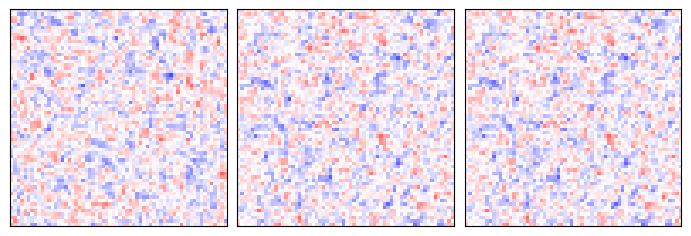

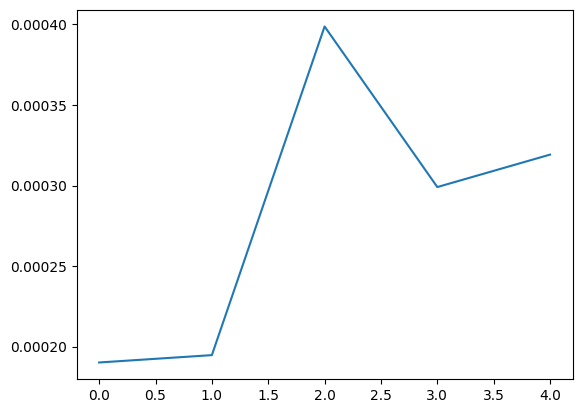

In [21]:
delta_in_fit_hat = fmodel.delta_in(posterior['q'][-1])
delta_in_fit = my_ifft(delta_in_fit_hat, cte.INV_L3)

delta_in_init_hat = fmodel.delta_in(q_init)
delta_in_init = my_ifft(delta_in_init_hat, cte.INV_L3)

plot_cubes([delta_in, delta_in_init, delta_in_fit], cmap='seismic_r', vlim=1e-1)



fig, ax = plt.subplots()

ax.plot(posterior['alpha'])

In [17]:
posterior['alpha']

Array([[1.99994201],
       [1.99996146],
       [1.99995113],
       [1.99987335],
       [1.99992737]], dtype=float64)

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='$k$ [$h$/Mpc]'>, <Axes: xlabel='$k$ [$h$/Mpc]'>,
        <Axes: xlabel='$k$ [$h$/Mpc]'>], dtype=object))

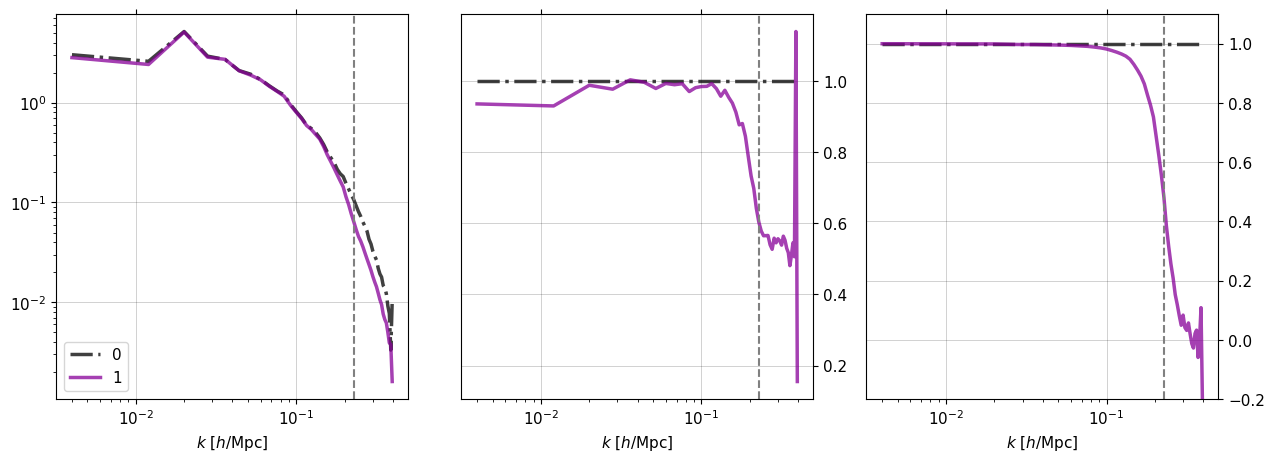

In [40]:
compare_pow_spec([delta_in, delta_in_fit], L=L, xlog=True)

In [ ]:
max_tree_depth = 6
adapt_mass_matrix = True
dense_mass = False

key = jax.random.PRNGKey(0)
kernel = NUTS(
    tempered_model,
    dense_mass=dense_mass,
    adapt_mass_matrix=adapt_mass_matrix,
    max_tree_depth=max_tree_depth,
)
mcmc = MCMC(kernel, num_warmup=20, num_samples=10, thinning=1, progress_bar=True)
mcmc.run(key, init_params=init_params, data=n_tr_data, T=100.0)
posterior = mcmc.get_samples()

sample: 100%|██████████| 30/30 [00:10<00:00,  2.83it/s, 31 steps of size 1.26e-01. acc. prob=0.26]


(<Figure size 707.107x353.553 with 2 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

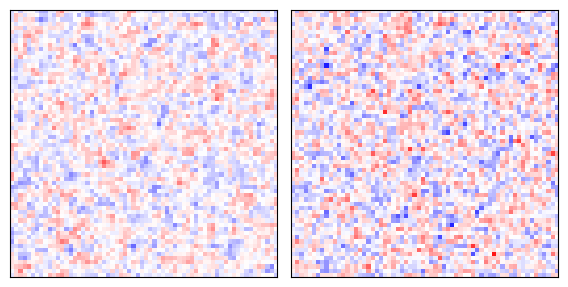

In [10]:
delta_in_fit_hat = fmodel.delta_in(posterior['q'][-1])
delta_in_fit = my_ifft(delta_in_fit_hat, cte.INV_L3)

plot_cubes([delta_in, delta_in_fit], cmap='seismic_r', vlim=1e-1)

In [ ]:
model = fmodel.build_model()

alpha_fixed = params["alpha"]
conditioned_model = handlers.condition(
    fmodel.build_model(),  # the model that still has sample("alpha", …)
    data={"alpha": jnp.array(alpha_fixed)},
)

def tempered_model(data, T=1):
    """Posterior ∝  [prior * likelihood]^(1/T)"""
    with handlers.scale(scale=1.0 / T):
        conditioned_model(data)

step_size = 1e-1  # choose by trial – no adaptation will adjust it
n_steps = 100
trajectory_length = step_size * n_steps  # path length = step_size × num_steps

#invM_diag = jnp.ones((N**3,)) * 0.5  # variance = 2

kernel = HMC(
    tempered_model,
    step_size=step_size,
    trajectory_length=trajectory_length,
    adapt_step_size=True,  # ⇢ no dual‑averaging
    adapt_mass_matrix=False,  # ⇢ keep identity mass matrix
    dense_mass=False,  # ⇢ diagonal identity
    find_heuristic_step_size=False,  # ⇢ do not override step_size
 #   inverse_mass_matrix=invM_diag,
)


mcmc = MCMC(kernel, num_warmup=100, num_samples=100, progress_bar=True)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, data=n_tr_data, T=10000.0)  # temperature 5, no adaptation
samples = mcmc.get_samples()

warmup:   2%|▏         | 3/200 [00:05<05:29,  1.67s/it, 435 steps of size 1.67e-03. acc. prob=0.00]

(<Figure size 707.107x353.553 with 2 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

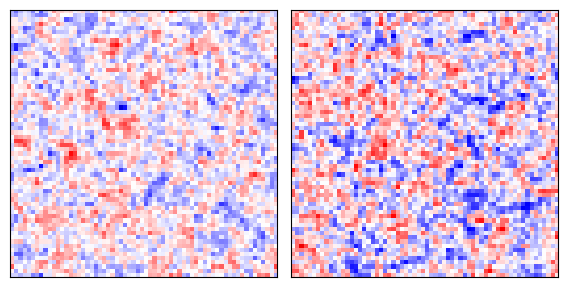

In [89]:
# print(posterior['alpha'])

# delta_in_init_hat = fmodel.delta_in(q_init)
# delta_in_init = my_ifft(delta_in_init_hat, cte.INV_L3)

delta_in_fit_hat = fmodel.delta_in(samples['q'][-1])
delta_in_fit = my_ifft(delta_in_fit_hat, cte.INV_L3)


plot_cubes([delta_in, delta_in_fit], cmap='seismic_r', vlim=1e-1)

In [ ]:
model = fmodel.build_model()

def tempered_model(data, T=1e3):
    """Posterior ∝  [prior * likelihood]^(1/T)"""
    with handlers.scale(scale=1.0 / T):
        fmodel.build_model()(data)        # call the original model

step_size          = 1e-3      # choose by trial – no adaptation will adjust it
n_steps = 100
trajectory_length  = step_size*n_steps       # path length = step_size × num_steps

invM_diag = jnp.ones((N**3+1,)) * 0.5        # variance = 2


kernel = HMC(
    tempered_model,
    step_size=step_size,
    trajectory_length=trajectory_length,
    adapt_step_size=False,         # ⇢ no dual‑averaging
    adapt_mass_matrix=False,       # ⇢ keep identity mass matrix
    dense_mass=False,              # ⇢ diagonal identity
    find_heuristic_step_size=False, # ⇢ do not override step_size
    inverse_mass_matrix=invM_diag,
)


mcmc = MCMC(kernel, num_warmup=0, num_samples=1000, progress_bar=True)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, data=n_tr_data, T=5.0)   # temperature 5, no adaptation
samples = mcmc.get_samples()

sample:   2%|▏         | 16/1000 [00:10<10:52,  1.51it/s, 100 steps of size 1.00e-03. acc. prob=0.00]


KeyboardInterrupt: 

In [ ]:
from numpyro.infer import MCMC, NUTS, HMC
from numpyro.infer.util import initialize_model




model = fmodel.build_model()

# key_init = jax.random.PRNGKey(1)
# q_init = fmodel.input_arr(key_init)
# init_params = {"q": q_init, 'b': jnp.atleast_1d(1.)}
rng_key = jax.random.PRNGKey(0)

init_params, _, _, _ = initialize_model(
    rng_key, model, model_kwargs={"data": n_tr_data}
)

max_tree_depth = 10
adapt_mass_matrix = True
dense_mass = False

key = jax.random.PRNGKey(0)
kernel = NUTS(
    model,
    dense_mass=dense_mass,
    adapt_mass_matrix=adapt_mass_matrix,
    max_tree_depth=max_tree_depth,
)
mcmc = MCMC(kernel, num_warmup=50, num_samples=5, thinning=1, progress_bar=True)
mcmc.run(
    key,  data=n_tr_data
)  # observed_counts is the galaxy map
posterior = mcmc.get_samples()

sample: 100%|██████████| 55/55 [01:50<00:00,  2.01s/it, 1023 steps of size 3.74e-04. acc. prob=0.92]


In [ ]:
# 1. extract final position and tuned HMC hyper‑params
z0      = mcmc.last_state.z
eps0    = mcmc.last_state.adapt_state.step_size
invM0   = mcmc.last_state.adapt_state.inverse_mass_matrix

# 2. new NUTS kernel re‑using mass matrix and step size; no further adaptation
kernel2 = NUTS(
    model,
    dense_mass=dense_mass,
    adapt_mass_matrix=False,
    adapt_step_size=False,
    step_size=eps0,
    inverse_mass_matrix=1.,
    max_tree_depth=max_tree_depth,
)

# 3. run more samples with warm‑up = 0
mcmc2 = MCMC(kernel2, num_warmup=0, num_samples=1000, progress_bar=True)
mcmc2.run(jax.random.PRNGKey(1), init_params=z0, data=n_tr_data)
posterior2 = mcmc2.get_samples()

sample:   0%|          | 4/1000 [00:28<1:56:28,  7.02s/it, 1023 steps of size 3.74e-04. acc. prob=0.91]


KeyboardInterrupt: 

[[0.0025875 ]
 [0.00295981]
 [0.00230673]
 [0.00357918]
 [0.00243069]]


(<Figure size 707.107x353.553 with 2 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

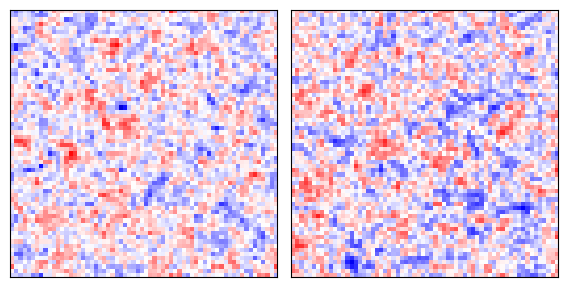

In [51]:
print(posterior['alpha'])

# delta_in_init_hat = fmodel.delta_in(q_init)
# delta_in_init = my_ifft(delta_in_init_hat, cte.INV_L3)

delta_in_fit_hat = fmodel.delta_in(posterior['q'][-1])
delta_in_fit = my_ifft(delta_in_fit_hat, cte.INV_L3)


plot_cubes([delta_in, delta_in_fit], cmap='seismic_r', vlim=1e-1)